In [4]:
from helpers import *

In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../models')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
from PIL import Image
import yaml
from utils import *
from helpers import *
import pickle
from scipy import stats

import pdb
from tqdm import tqdm

from dlclive import DLCLive, Processor

ModuleNotFoundError: No module named 'utils'

In [2]:
class DataManager:
    def __init__(self, keys=[]):
        self.data = {key: [] for key in keys}
    
    def _print_key_error(self, key):
        print(f"Key '{key}' does not exist in the data manager.")

    def add_nan(self, key, shape):
        data_ = self.data[key]
        pop_count = 0
        while len(data_) > 0 and data_[-1] is None:
            data_.pop()
            pop_count += 1
        while pop_count > 0:
            data_.append(np.full(shape, np.nan))
            pop_count -= 1

    def add(self, key, value):
        if key in self.data:
            if value is not None:
                self.add_nan(key, value.shape)
            self.data[key].append(value)
        else:
            self._print_key_error(key)

    def to_numpy(self):
        for key in self.data:
            data_ = self.data[key]
            if len(data_) == 0 or data_[0] is None:
                self.data[key] = None
                return
            self.add_nan(key, data_[0].shape)
            self.data[key] = np.array(data_)

    def save(self, dir):
        for key in self.data:
            np.save(f'{dir}/{key}.npy', self.data.get(key))

    def load(self, dir, keys):
        if keys is None:
            keys = self.data.keys
        for key in keys:
            self.data[key] = np.load(f'{dir}/{key}.npy')
        return self.data

    def remove(self, key):
        if key in self.data:
            del self.data[key]
        else:
            self._print_key_error(key)

    def get(self, key):
        if key in self.data:
            return self.data[key]
        else:
            self._print_key_error(key)
            return None

In [3]:
class DLCManager:
    def __init__(self, 
            model_path,
            processor=Processor(),
            pcutoff=0.2,
            resize=1):
        
        self.model = DLCLive(
            model_path=model_path,
            processor=processor,
            pcutoff=pcutoff,
            # display=True,
            resize=resize)
        self.frame = None
        self.is_first_frame = None
        self.dm = DataManager()

    def init_data(self, feature_keys):
        self.dm = DataManager(feature_keys)
        self.prev_pose_xy = None
        
    def update_frame(self, frame, is_first_frame):
        self.frame = frame
        self.is_first_frame = is_first_frame
        
    def detect_pose_helper(self):
        if self.is_first_frame:
            pose = self.model.init_inference(self.frame)
        else:
            pose = self.model.get_pose(self.frame)
        return pose
        
    def detect_pose(self):
        curr_pose = self.detect_pose_helper()
        
        curr_pose_xy, curr_pose_p = curr_pose[:, :-1], curr_pose[:, -1]
        if self.prev_pose_xy is None:
            self.prev_pose_xy = curr_pose_xy

        pose = np.stack([self.prev_pose_xy, curr_pose_xy])
        feature_angles_item, pose_speed_item = extract_pose_features(pose)

        self.dm.add('xy', curr_pose_xy)
        self.dm.add('p', curr_pose_p)
        self.dm.add('angles', feature_angles_item)
        self.dm.add('speed', pose_speed_item)

        self.prev_pose_xy = curr_pose_xy

    def save_data(self, dir):
        self.dm.to_numpy()
        self.dm.save(dir)

    def load_data(self, dir, feature_keys):
        return self.dm.load(dir, feature_keys)

In [4]:
class Driver:
    def __init__(self, config_file, dev_mode = False, video_type=None, verbose = True):
        with open(f'configs/{config_file}.yaml', 'r') as file:
            config = yaml.safe_load(file)
        self.is_metadata_present = (config['path']['xls'] is not None)
        self.fps = config['info']['fps']
        root_dir = config['path']['root']
        self.video_dir = f"{root_dir}/{config['path']['video']}"

        if self.is_metadata_present:
            xls_path = f"{root_dir}/{config['path']['xls']}"
            self.files_info = read_octopus_xlsx(xls_path)
            if video_type == "Mech":
                self.files_info = self.files_info[self.files_info['Stim Method'] == 'Mechanical']
            elif video_type == "Elec":
                self.files_info = self.files_info[self.files_info['Stim Method'] == 'Electrical']
            else:
                pass
                
            self.filenames = self.files_info["File Name"].to_list()
        else:
            self.filenames = [os.path.splitext(file)[0] for file in os.listdir(self.video_dir)]

        self.working_dir = f"{root_dir}/{config['path']['working']}" # to save processed data and figures

        model_path = f"{root_dir}/{config['path']['model']}"

        self.feature_keys = ['xy', 'p', 'angles', 'speed']
        self.dlc = DLCManager(model_path)
        
        self.prosvd_k = 4 # no. of dims to reduce to

        self.time_margin = (-20, 180) # to trim videos
        self.total_f = self.time_margin[1] - self.time_margin[0]

        self.tx = np.arange(self.time_margin[0], self.time_margin[1])/self.fps

        # if self.is_metadata_present:
        #     self.stim_class_list = sorted(self.files_info['Stimulation Class'].unique().tolist())
        # else:
        self.stim_class_list =  ['Cord Electrical', 'Distal Electrical', 'Proximal Electrical', 'Cord Mechanical', 'Distal Mechanical', 'Proximal Mechanical']


        self.movement_types = [
            "No movement",
            "Movement",
            "Movement with arm curl"
        ]

        if dev_mode:
            self.files_info = self.files_info.iloc[[2]]
            self.filenames = self.files_info["File Name"].to_list()

        if verbose:
            print(f"Processing {len(self.filenames)} videos from {self.video_dir}")
            if len(self.filenames) < 4:
                print('\t', end='')
                print(*self.filenames, sep="\n\t")

    def get_fig_dir(self, filename):
        figs_dir = f"{self.working_dir}/figs"
        os.makedirs(figs_dir, exist_ok=True)
        return figs_dir

    def get_data_dir(self, filename=None):
        if filename is None:
            data_dir = f"{self.working_dir}"
        else:
            data_dir = f"{self.working_dir}/data/{filename}"
        os.makedirs(data_dir, exist_ok=True)
        return data_dir
    
    def load_video(self, video_idx):
        video_filename = self.filenames[video_idx]

        self.video = None
        try:
            self.video = load_video(self.video_dir, video_filename)
        except:
            return False

        self.index = -1

        self.dlc.init_data(feature_keys=self.feature_keys)

        return (self.video is not None)
    
    def is_video_empty(self):
        return self.video is None or not self.video.isOpened()
    
    def read_video(self):
        ret, self.frame = self.video.read()
        if not ret: return False
        # if not self.frame:
        #     pdb.set_trace()
        self.frame = self.frame[:,:,::-1]
        self.index += 1
        self.dlc.update_frame(self.frame, self.index == 0)
        return ret
    
    def release_video(self):
        self.video.release()
    
    def detect_pose(self):
        self.dlc.detect_pose()

    def save_data(self, video_idx):
        video_filename = self.filenames[video_idx]
        data_dir = self.get_data_dir(video_filename)
        self.dlc.save_data(data_dir)

    def post_process(self, verbose=False):
        err_log = {
            'poor_pose': [],
            'file_missing': []
        }

        columns = ['filename', *self.feature_keys, 'move_class', 'stim_class']
        df = pd.DataFrame(columns=columns)

        for video_idx in range(len(self.filenames)):
            video_filename = self.filenames[video_idx]

            data_dir = self.get_data_dir(video_filename)

            try:
                features = self.dlc.load_data(data_dir, self.feature_keys)
            except ValueError:
                err_log['poor_pose'].append(video_filename)
                continue
            except FileNotFoundError:
                err_log['file_missing'].append(video_filename)
                continue
            except:
                raise("Uncaught exception")
            
            row = None
            if self.is_metadata_present:
                row = self.files_info.iloc[video_idx]
            md = load_metadata_new(row, time_margin = self.time_margin)

            start_f, end_f = md[0], md[1]

            data = {}

            for key, value in features.items():
                data[key] = value[start_f: end_f, ...]

            move_idx, stim_idx = 0, 0
            if self.is_metadata_present:
                move_idx = int(row['Classification'])
                stim_class = row["Stimulation Class"]
                stim_idx =  self.stim_class_list.index(stim_class)

            data['filename'] = video_filename
            data['move_class'] = move_idx
            data['stim_class'] = stim_idx

            df = df.append(data, ignore_index=True)

        if verbose:
            for key, items in err_log.items():
                print(f"{key}: {len(items)}")
                for item in items:
                    print(f"\t{item}")

        data_dir = self.get_data_dir()

        feature_key_tuple = [('features', key) for key in self.feature_keys]

        df.columns = pd.MultiIndex.from_tuples([
            ('metadata', 'filename'),
            *feature_key_tuple,
            ('labels', 'move_class'),
            ('labels', 'stim_class')
        ])

        with open(f'{data_dir}/dlc_features.pkl', 'wb') as f:
            pickle.dump(df, f)

    def visualize_results(self):
        num_lines = 3 # for 3 angles
        colors = plt.cm.Paired(np.linspace(0, 1, num=num_lines))

        num_rows, num_cols = 1, 3
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 4), gridspec_kw={'top': 0.85})

        for i, key in enumerate(self.feature_angles_dict.keys()):
            feature_angle_mean = np.mean(self.feature_angles_dict[key], axis=0)

            for k in range(3):
                data = feature_angle_mean[..., k]
                data = smooth_data(data, 5)
                axs[i].plot(data, label=k, linewidth=2, c=colors[k])
            axs[i].set_ylim(-10, 190)
            axs[i].set_title(key)
            axs[i].set_xlabel("Time (s)")
            axs[i].axvline(x=0, color='orange', linewidth=2, alpha=0.3)

        legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=i) for i in range(3)]
        fig.legend(title="Angle", handles=legend_elements, loc='upper right')
        fig.suptitle(f'Electrical Stimulations - Angle')

        figs_dir = self.get_fig_dir("")
        figs_dir_full = f'{figs_dir}/dlc-summary'
        os.makedirs(figs_dir_full, exist_ok=True)
        fig.savefig(f'{figs_dir_full}/Electrical Stimulations - Angle.png', facecolor='white')
    

In [5]:
driver = Driver("octo-17")

Processing 148 videos from /home/sachinks/Code/MyProjects/OctopusVideos/videos


In [6]:
def process_all_data():
    for video_idx in tqdm(range(len(driver.filenames))):
        ret = driver.load_video(video_idx)
        if not ret:
            continue

        while not driver.is_video_empty():
            ret = driver.read_video()
            if not ret:
                break

            driver.detect_pose()

        driver.release_video()

        driver.save_data(video_idx)

    driver.post_process()

# process_all_data()

In [7]:
# Helper functions

# Load features

def load_features(proSVD=True, verbose=True):
    data_dir = driver.get_data_dir()
    with open(f'{data_dir}/dlc_features.pkl', 'rb') as f:
        df = pickle.load(f)
    df.drop([('features', 'angles'), ('features', 'speed')], axis=1, inplace=True)
    
    if proSVD:
        with open(f'{data_dir}/proSVD_features.pkl', 'rb') as f:
            df_prosvd = pickle.load(f)

        df = pd.merge(df, df_prosvd, on=[('metadata', 'filename')], how='inner')

    if verbose:
        print(df.shape)
        display(df.head(2))
    return df

# Add features

def add_features(df, skeleton_thresh=0.4):
    def add_columns(key, fn):
        new_column_data = df.apply(fn, axis=1)
        ins_pos = df.columns.get_loc(('labels', 'move_class'))
        df.insert(ins_pos, ('features', key), new_column_data)

    def compute_speed(row):
        xy = row[('features', 'xy')]
        return find_speed(xy)

    def compute_skeleton(row):
        xy = row[('features', 'xy')]
        return find_point_point_distance(xy)

    def compute_pred_acc(row):
        skeleton = row[('features', 'skeleton')]
        acc = np.sum(skeleton < skeleton_thresh)/len(skeleton)
        return acc

    add_columns('speed', compute_speed)    
    add_columns('skeleton', compute_skeleton)

    new_column_data = df.apply(compute_pred_acc, axis=1)
    ins_pos = df.columns.get_loc(('labels', 'stim_class'))
    df.insert(ins_pos+1, ('labels', 'pred_acc'), new_column_data)

    return df

In [8]:
# Load & Add

df_features = load_features(proSVD=True, verbose = False)
df_features = add_features(df_features, skeleton_thresh=0.4)
display(df_features.head(2))
for feat in ['xy', 'speed', 'skeleton', 'dQ']:
    print(feat, '\t\t', df_features[('features', feat)][0].shape)

metadata  \
                                      filename   
0  elec_right_cord_100Hz_5mA_220616_131634_000   
1             proximal_pinch_220616_115258_000   

                                            features  \
                                                  xy   
0  [[[396.07852, 200.0402], [387.49155, 203.54031...   
1  [[[393.59735, 199.79143], [387.9191, 203.76796...   

                                                      \
                                                   p   
0  [[0.99997187, 0.99991876, 0.999936, 0.9998191,...   
1  [[0.99996316, 0.9992906, 0.99981815, 0.9999482...   

                                                      \
                                               speed   
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                         labels             \
                                            skeleton move_class stim_class   
0  [0.16959439, 0.16910106, 0.17221986, 0.1695351...          0          0   
1  [0.11659259, 0.11997385, 0.11871561, 0.1105882...          0          5   

                                                     features  
  pred_acc                                                 dQ  
0     1.00  [[0.0, 0.0, 0.0, 0.0], [0.006909703216576469, ...  
1     0.76  [[0.0, 0.0, 0.0, 0.0], [0.011314186517125095, ...

xy 		 (200, 17, 2)
speed 		 (200, 17)
skeleton 		 (200,)
dQ 		 (200, 4)


In [10]:
# Extract features

XY = df_features['features', 'xy'].values
proSVD_f = df_features['features', 'dQ'].values
N = len(XY)
mean_angle = np.zeros((N, 3))
max_angle = np.zeros((N, 3))
mean_angular_speed = np.zeros((N, 3))
max_angular_speed = np.zeros((N, 3))
mean_distal_speed = np.zeros((N, 3))
max_distal_speed = np.zeros((N, 3))
total_displacement = np.zeros((N, XY[0].shape[1]))
max_proSVD_dq = np.zeros((N, 3))

## intervals for computing the features
break_intervals = convert_from_seconds_to_frames([
    [0, 1], # 1 second immediately following stimulation
    [1, 2], # 1-2 sec
    [2, None] # > 2 sec
], driver.fps, driver.time_margin)

for i in range(N):
    xy = np.copy(XY[i])
    xy = clean_XY_by_speed(xy)
    # xy = clean_XY_by_point_position(xy)

    distal_speed = find_speed(xy)[:,-1] # speed of distal point
    # distal_speed = np.mean(find_speed(xy), axis=-1)


    feat = np.diff(xy, axis=-2)
    angle_array = np.zeros(feat.shape[0])
    for t in range(feat.shape[0]):
        angle_array[t] = angle_between(feat[t, 0], feat[t, -1])

    # total_displacement[i] = 
    init_pos = np.mean(xy[:30], axis=0)
    final_pos = np.mean(xy[-30:], axis=0)
    total_displacement[i] = np.linalg.norm(final_pos-init_pos, axis=-1)
    L = compute_L(xy).mean()
    total_displacement[i] /= L

    for j, intv in enumerate(break_intervals):
        s, e = intv
        mean_angle[i, j] = np.mean(angle_array[s:e])
        max_angle[i, j] = np.max(angle_array[s:e])
        angular_speed = driver.fps * 1e-3 * np.abs(np.diff(angle_array))
        mean_angular_speed[i, j] = np.mean(angular_speed[s:e])
        max_angular_speed[i, j] = np.percentile(angular_speed[s:e], 95)
        mean_distal_speed[i, j] = np.mean(distal_speed[s:e])
        max_distal_speed[i, j] = np.max(distal_speed[s:e])

        max_proSVD_dq[i, j] = np.max(proSVD_f[i][s:e, 1])

In [13]:
# df_dict = {
#     'filename': [],
#     'move_class': [],
#     'feature(0)': [],
#     'feature(1)': [],
#     'feature(2)': [],
# }
# feature_ = max_distal_speed

# for i in range(N):
#     df_dict['filename'].append(df_features[('metadata', 'filename')].iloc[i])
#     for j in range(feature_.shape[-1]):
#         df_dict[f'feature({j})'].append(feature_[i][j])
#     df_dict['move_class'].append(df_features[('labels', 'move_class')].iloc[i])
# df_dict = pd.DataFrame(df_dict)
# df_dict.head(1)

,filename,move_class,feature(0),feature(1),feature(2)
0,elec_right_cord_100Hz_5mA_220616_131634_000,0,0.022193,0.02189,0.022418


In [21]:
driver.stim_class_list

['Cord Electrical',
 'Distal Electrical',
 'Proximal Electrical',
 'Cord Mechanical',
 'Distal Mechanical',
 'Proximal Mechanical']

In [47]:
# def add_extra_stim_labels():
# display(df_new_features['label_stim'].value_counts().sort_index())
# display(df_new_features['labelname_stim'].value_counts().sort_values())
# print(driver.stim_class_list)

def remove_duplicates(original_list):
    return list(dict.fromkeys(original_list))

def add_stim_labels(value, type):
    loc, stim = value.split(" ")
    res = ""
    if type == 1:
        if loc in ["Distal", "Proximal"]:
            res += "PD"
        elif loc == "Cord":
            res += "Cord"
        else:
            res += "XXX"
        res += " " + stim
        return res
    elif type == 2:
        if loc in ["Distal", "Proximal"]:
            res += "PD"
        elif loc == "Cord":
            res += "Cord"
        else:
            res += "XXX"
        return res

In [71]:
def get_colors(n=6, label=''):
    # Define hues of red and blue
    red_palette = sns.color_palette("Reds", n_colors=3)
    blue_palette = sns.color_palette("Blues", n_colors=3)

    if n%2:
        if label == "MOVE":
            all_colors = blue_palette
        else:
            all_colors = red_palette
    else:
        all_colors = red_palette[:n//2] + blue_palette[:n//2]
    return all_colors

def get_label_details(label, type):
    if label == "MOVE":
            label_field = 'label_move'
            label_names = driver.movement_types
    if label == "STIM":
        if type is None:
            label_field = 'label_stim'
            label_names = driver.stim_class_list
        else:
            label_field = f'label_stim_{type}'
            label_names = remove_duplicates([add_stim_labels(x, type=type) for x in driver.stim_class_list])
            
    return label_field, label_names
        

,Mean angular speed (0),Max angular speed (0),Mean distal speed (0),Max distal speed (0),Max proSVD feature (0),Mean angular speed (1),Max angular speed (1),Mean distal speed (1),Max distal speed (1),Max proSVD feature (1),...,Total displacement (11),Total displacement (12),Total displacement (13),Total displacement (14),Total displacement (15),Total displacement (16),label_stim,label_move,label_stim_1,label_stim_2
0,0.104277,0.223532,0.010901,0.022193,0.130694,0.131073,0.222768,0.012649,0.021890,0.080982,...,0.000424,0.000899,0.000611,0.002596,0.000184,0.008087,Cord Electrical,No movement,Cord Electrical,Cord
1,0.967759,2.792206,0.011637,0.045693,0.134904,0.523930,1.556209,0.008293,0.037744,0.070013,...,0.040034,0.585194,0.387806,0.052773,0.057823,0.064207,Proximal Mechanical,No movement,PD Mechanical,PD


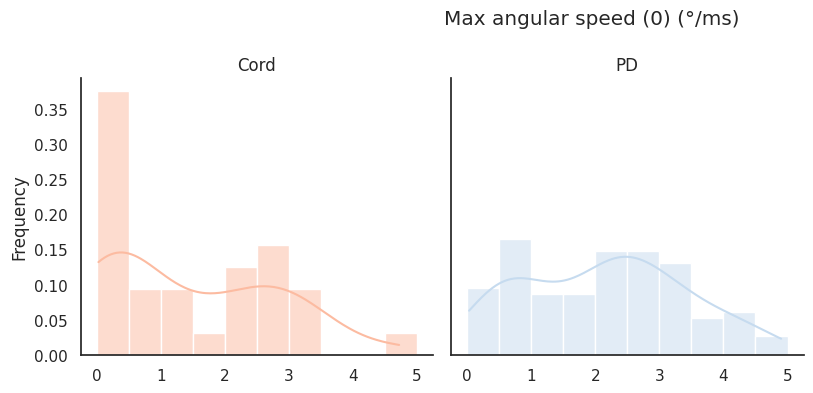

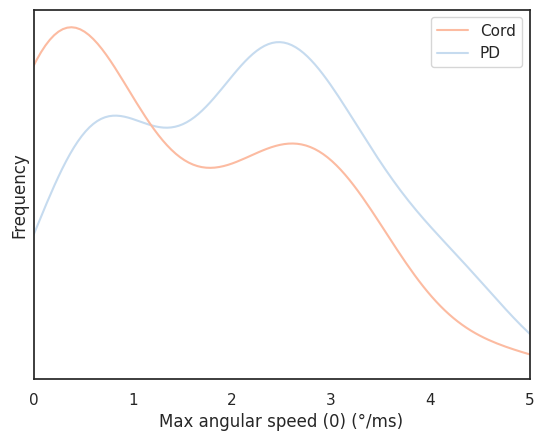

In [58]:
# Plot visualization

def load_feature_df():
    df_dict = {}
    for i in range(3):
        df_dict[f'Mean angular speed ({i})'] = mean_angular_speed[:, i]
        df_dict[f'Max angular speed ({i})'] = max_angular_speed[:, i]
        df_dict[f'Mean distal speed ({i})'] = mean_distal_speed[:, i]
        df_dict[f'Max distal speed ({i})'] = max_distal_speed[:, i]
        df_dict[f'Max proSVD feature ({i})'] = max_proSVD_dq[:, i]

    for i in range(total_displacement.shape[-1]):
        df_dict[f'Total displacement ({i})'] = total_displacement[:, i]

    df = pd.DataFrame(df_dict)

    label_names = driver.stim_class_list
    df['label'] = df_features['labels', 'stim_class']
    df['label_stim'] = df.apply(lambda row: label_names[row['label']], axis=1)
    df.drop('label', axis=1, inplace=True) 

    label_names = driver.movement_types
    df['label'] = df_features['labels', 'move_class']
    df['label_move'] = df.apply(lambda row: label_names[row['label']], axis=1)
    df.drop('label', axis=1, inplace=True)

    max_type = 2
    for type in range(1, max_type+1):
        label_names = remove_duplicates([add_stim_labels(x, type=type) for x in driver.stim_class_list])
        df[f'label_stim_{type}'] = df['label_stim'].apply(lambda row: add_stim_labels(row, type))
    return df

def visualize_hist_separate(df, feature, label="STIM", type=None):
    # Set up Seaborn style
    sns.set(style="white")

    # Calculate bin edges
    mini, maxi = np.floor(df[feature].min()), np.ceil(df[feature].max())
    if maxi - mini == 1: maxi = 0.1*np.round(10*df[feature].max())
    bin_width = 0.1 * (maxi-mini)  # Adjust as needed
    bin_edges = np.arange(mini, maxi + bin_width, bin_width)
    x_labels = np.linspace(mini, maxi, 6)

    if label == "MOVE":
            label_names = driver.movement_types
            label_field = 'label_move'
    if label == "STIM":
        if type is None:
            label_names = driver.stim_class_list
            label_field = 'label_stim'
        else:
            label_names = remove_duplicates([add_stim_labels(x, type=type) for x in driver.stim_class_list])
            label_field = f'label_stim_{type}'
    
    label_field, label_names = get_label_details(label, type)
    class_size = len(label_names)
    all_colors = get_colors(class_size, label)
         
    # Create a FacetGrid with histograms for each label
    col_wrap = class_size//2 if class_size>3 else 3
    g = sns.FacetGrid(df, col=label_field, col_wrap=col_wrap, height=4, sharex=True)
    # Iterate through subplots to set x-axis ticks and labels
    for i, ax in enumerate(g.axes.flat):
        label_value = label_names[i]
        df_ = df[df[label_field] == label_value]
        sns.histplot(data=df_, x=feature, stat="probability", kde=True, bins=bin_edges, ax=ax, color=all_colors[i], common_norm=False)

        ax.set_xticks(x_labels)
        ax.set_title(df_[label_field].iloc[0])

    # Set axis labels
    g.set_axis_labels("", "Frequency")

    unit = find_unit(feature)
    if unit is not '': unit = f" ({unit})"
    plt.suptitle(f"{feature}{unit}")
    # plt.subplots_adjust(hspace=0.2) 
    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    hue_mapping = {}
    for key, value in zip(label_names, all_colors):
        hue_mapping[key] = value

    sns.kdeplot(data=df, x=feature, common_norm=False, hue=label_field, palette=hue_mapping)

    # Add title and labels
    plt.xlabel(f"{feature}{unit}")
    plt.ylabel('Frequency')
    plt.xlim(mini, maxi)
    plt.xticks(x_labels)
    plt.yticks([])
    plt.gca().get_legend().set_title('')

    # Show the plot
    plt.show()

df_new_features = load_feature_df()
display(df_new_features.head(2))
T = 0
feature_name = 'Max angular speed'
stim_type = 2
visualize_hist_separate(df_new_features, f'{feature_name} ({T})', f"STIM", type=stim_type)



In [55]:
# KS-test 1
locations = ['Cord', 'Distal', 'Proximal']
stimulations = ['Electrical', 'Mechanical']


featr_list = df_new_features.columns.to_list()[:-2]

res2 = {}

for featr in featr_list:
    res = {}
    res2[featr] = []

    for loc in locations:
        data = []
        
        for stim in stimulations:
            label_name = f'{loc} {stim}'
            data_ = df_new_features.query(f'label_stim == "{label_name}"')
            data.append(data_[featr])
        data1, data2 = data

        ks_statistic, p_value = stats.ks_2samp(data1, data2)
        
        # Interpret the results
        alpha = 0.05  # Set your desired significance level

        res_string = ''

        if p_value < alpha:
            res_string = 'different'
        else:
            res_string = 'same'

        res[loc] = [f'{p_value:.2f}', res_string]
        res2[featr].append(f'{res_string}-{p_value:.2f}')
    # print(featr)
    # display(pd.DataFrame(res, index=['p-value', 'distribution']))
    # print()

df_frame = pd.DataFrame(res2).T
df_frame.columns = locations
print("K-S test p-value comparing Elec & Mech")
# display(df_frame)

K-S test p-value comparing Elec & Mech


In [57]:
# KS-test 2
locations1 = ['Cord', 'Distal', 'Proximal']
locations2 = locations[1:] + [locations[0]]

stims = ['Electrical', 'Mechanical']

featr_list = df_new_features.columns.to_list()[:-2]

res2 = {}

for featr in featr_list:
    res = {}
    res2[featr] = []

    for loc1, loc2 in zip(locations1, locations2):
        data = []

        stims_ = [f'{loc1} {stims[0]}', f'{loc1} {stims[1]}']
        data1 = df_new_features.query(f'label_stim in ["{stims_[0]}", "{stims_[1]}"]')[featr]


        stims_ = [f'{loc2} {stims[0]}', f'{loc2} {stims[1]}']
        data2 = df_new_features.query(f'label_stim in ["{stims_[0]}", "{stims_[1]}"]')[featr]

        ks_statistic, p_value = stats.ks_2samp(data1, data2)

        alpha = 0.05  # Set your desired significance level

        res_string = ''

        if p_value < alpha:
            res_string = 'different'
        else:
            res_string = 'same'

        res[f'{loc1} v/s {loc2}'] = [f'{p_value:.2f}', res_string]
        res2[featr].append(f'{res_string}-{p_value:.2f}')

df_frame = pd.DataFrame(res2).T

df_frame.columns = [f'{loc1} v/s {loc2}' for loc1, loc2 in zip(locations1, locations2)]
print("K-S test p-value comparing stimulus locations")
# display(df_frame)

K-S test p-value comparing stimulus locations


In [38]:
features_list = df_new_features.columns.to_list()
print(features_list)
features_to_compare = [
    [features_list[0], features_list[1]],
    [features_list[2], features_list[3]],
    [features_list[0], features_list[2]],
    [features_list[1], features_list[3]]
]
print(features_to_compare)

['Mean angular speed (0)', 'Max angular speed (0)', 'Mean distal speed (0)', 'Max distal speed (0)', 'Max proSVD feature (0)', 'Mean angular speed (1)', 'Max angular speed (1)', 'Mean distal speed (1)', 'Max distal speed (1)', 'Max proSVD feature (1)', 'Mean angular speed (2)', 'Max angular speed (2)', 'Mean distal speed (2)', 'Max distal speed (2)', 'Max proSVD feature (2)', 'Total displacement (0)', 'Total displacement (1)', 'Total displacement (2)', 'Total displacement (3)', 'Total displacement (4)', 'Total displacement (5)', 'Total displacement (6)', 'Total displacement (7)', 'Total displacement (8)', 'Total displacement (9)', 'Total displacement (10)', 'Total displacement (11)', 'Total displacement (12)', 'Total displacement (13)', 'Total displacement (14)', 'Total displacement (15)', 'Total displacement (16)', 'label', 'label_name']
[['Mean angular speed (0)', 'Max angular speed (0)'], ['Mean distal speed (0)', 'Max distal speed (0)'], ['Mean angular speed (0)', 'Mean distal spee

In [74]:
from scipy.stats import multivariate_normal

display(df_new_features.head(1))
red_palette = sns.color_palette("Reds", n_colors=3)
blue_palette = sns.color_palette("Blues", n_colors=3)
all_colors = red_palette + blue_palette

feat1, feat2 = 'Max angular speed (0)', 'Max distal speed (0)'

df = df_new_features

df[f'{feat1}_normed'] = (df[feat1] - df[feat1].mean()) / df[feat1].std()
df[f'{feat2}_normed'] = (df[feat2] - df[feat2].mean()) / df[feat2].std()

sns.scatterplot(x=f'{feat1}_normed', y=f'{feat2}_normed',
                 hue='label_name', palette=all_colors,
                  legend=False, data=df_new_features)
# print(df[[feat1, feat2]].mean())

for i, label in enumerate(driver.stim_class_list):
    subset = df[df['label_name'] == label][[f'{feat1}_normed', f'{feat2}_normed']]
    
    # Fit 2D Gaussian
    mean = subset.mean()
    cov_matrix = np.cov(subset.values.T)
    mvn = multivariate_normal(mean=mean, cov=cov_matrix)
    
    # Generate points for the ellipse
    angle = np.degrees(np.arctan2(*cov_matrix[::-1, :][0]))
    width, height = np.sqrt(5.991 * cov_matrix.diagonal())
    ellipse = plt.matplotlib.patches.Ellipse(mean, width, height, angle, color=all_colors[i], alpha=0.2)
    ellipse2 = plt.matplotlib.patches.Ellipse(mean, width, height, angle, fill=False, edgecolor=all_colors[i], linewidth=2)
    # Plot the ellipse
    plt.gca().add_patch(ellipse)
    plt.gca().add_patch(ellipse2)

# Add labels and title
plt.xlabel(feat1 + ' normalized')
plt.ylabel(feat2 + ' normalized')

# Show the plot
plt.show()

,Mean angular speed (0),Max angular speed (0),Mean distal speed (0),Max distal speed (0),Max proSVD feature (0),Mean angular speed (1),Max angular speed (1),Mean distal speed (1),Max distal speed (1),Max proSVD feature (1),...,Total displacement (11),Total displacement (12),Total displacement (13),Total displacement (14),Total displacement (15),Total displacement (16),label_stim,label_move,label_stim_1,label_stim_2
0,0.104277,0.223532,0.010901,0.022193,0.130694,0.131073,0.222768,0.012649,0.02189,0.080982,...,0.000424,0.000899,0.000611,0.002596,0.000184,0.008087,Cord Electrical,No movement,Cord Electrical,Cord


ValueError: Could not interpret value `label_name` for parameter `hue`

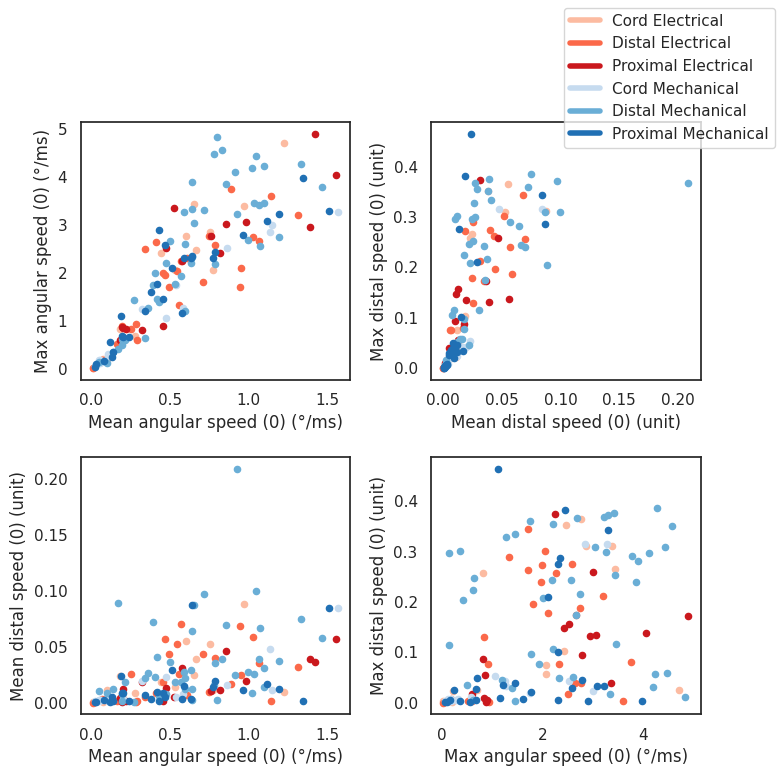

In [39]:
# Electrical Stimulations - Movement

num_rows, num_cols = 2, 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 8), gridspec_kw={'top': 0.85})

class_list = driver.stim_class_list
no_of_points = len(class_list)

red_palette = sns.color_palette("Reds", n_colors=3)
blue_palette = sns.color_palette("Blues", n_colors=3)

# Combine the palettes
if LABEL == "STIM":
    all_colors = red_palette + blue_palette
elif LABEL == "MOVE":
    all_colors = blue_palette

for c in range(no_of_points):
    class_data = df_new_features.query(f'label == {c}')
    for i in range(num_rows):
        for j in range(num_cols):
            k = i*num_cols + j
            to_compare = features_to_compare[k]
            x_lb, y_lb = to_compare
            axs[i, j].scatter(class_data[x_lb], class_data[y_lb],
                color=all_colors[c], label=class_list[c], s=20)
            
            axs[i, j].set_xlabel(f'{x_lb} ({find_unit(x_lb)})')
            axs[i, j].set_ylabel(f'{y_lb} ({find_unit(y_lb)})')

legend_elements = [Line2D([0], [0], color=all_colors[i], lw=4, label=class_list[i]) for i in range(no_of_points)]
fig.legend(title="", handles=legend_elements, loc='upper right')
fig.suptitle(f'')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [56]:
display(df_features['labels', 'move_class'].value_counts().sort_index().to_frame())
display(df_features['labels', 'stim_class'].value_counts().sort_index().to_frame())
print('0.Cord 1.Distal 2.Proximal')

,labels
,move_class
0,38
1,29
2,24


,labels
,stim_class
0,18
1,45
2,28


0.Cord 1.Distal 2.Proximal


In [100]:
df_new_features.head(1)

,Mean angular speed (0),Max angular speed (0),Mean distal speed (0),Max distal speed (0),Max proSVD feature (0),Mean angular speed (1),Max angular speed (1),Mean distal speed (1),Max distal speed (1),Max proSVD feature (1),...,Total displacement (11),Total displacement (12),Total displacement (13),Total displacement (14),Total displacement (15),Total displacement (16),label_stim,label_move,label_stim_1,label_stim_2
0,0.104277,0.223532,0.010901,0.022193,0.130694,0.131073,0.222768,0.012649,0.02189,0.080982,...,0.000424,0.000899,0.000611,0.002596,0.000184,0.008087,Cord Electrical,No movement,Cord Electrical,Cord


In [119]:
print(pca.components_.shape)
print(data.shape)
# display(pca.components_)
print(data.columns.tolist())

(32, 32)
(147, 32)
['Mean angular speed (0)', 'Max angular speed (0)', 'Mean distal speed (0)', 'Max distal speed (0)', 'Max proSVD feature (0)', 'Mean angular speed (1)', 'Max angular speed (1)', 'Mean distal speed (1)', 'Max distal speed (1)', 'Max proSVD feature (1)', 'Mean angular speed (2)', 'Max angular speed (2)', 'Mean distal speed (2)', 'Max distal speed (2)', 'Max proSVD feature (2)', 'Total displacement (0)', 'Total displacement (1)', 'Total displacement (2)', 'Total displacement (3)', 'Total displacement (4)', 'Total displacement (5)', 'Total displacement (6)', 'Total displacement (7)', 'Total displacement (8)', 'Total displacement (9)', 'Total displacement (10)', 'Total displacement (11)', 'Total displacement (12)', 'Total displacement (13)', 'Total displacement (14)', 'Total displacement (15)', 'Total displacement (16)']


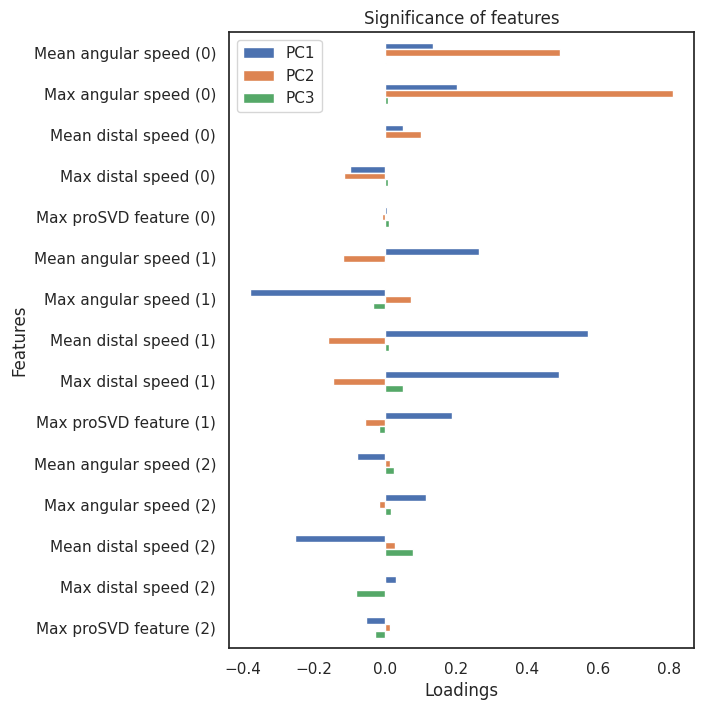

In [137]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate some example data
np.random.seed(0)
data = df_new_features.select_dtypes(include='float64')

# Perform PCA
pca = PCA()
pca.fit(data)

# Access the loadings for the first two principal components for the three most important features
n_features_to_plot = 15
loadings_for_plot = pca.components_[:n_features_to_plot, :3]

# Create a DataFrame to display the loadings
features = data.columns.tolist()[:n_features_to_plot]
loadings_df = pd.DataFrame(loadings_for_plot, columns=['PC1', 'PC2', 'PC3'], index=features)

# Plot the loadings as a bar chart
ax = loadings_df.plot(kind='barh', figsize=(6, 8))
ax.invert_yaxis()
plt.xlabel('Loadings')
plt.ylabel('Features')
plt.title('Significance of features')
plt.xticks(rotation=0)
plt.show()


In [91]:
loadings.shape

(2, 5)

In [96]:
data=np.vstack([loadings[0, top_features_pc1], loadings[1, top_features_pc2]])
data

array([[ 0.5063108 ,  0.51154917,  0.54648931],
       [-0.41011012,  0.47386964, -0.6498715 ]])

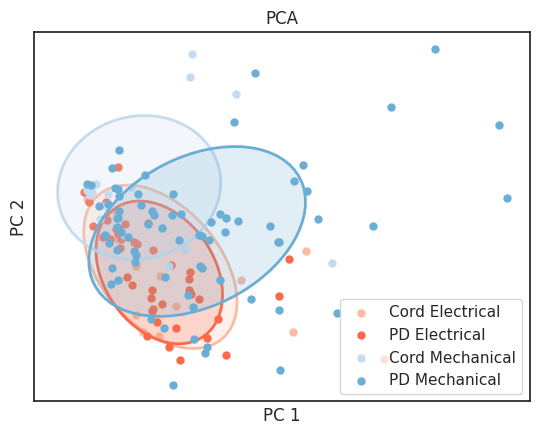

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new_features = load_feature_df()

data = df_new_features.select_dtypes(include='float64')


label_class = "STIM"
label_field, label_names = get_label_details(label_class, 1)
all_colors = get_colors(len(label_names), label_class)

data_labels = df_new_features[label_field].to_frame()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA() #(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


# no_of_points = len(label_names)

for c, label in enumerate(label_names):
    indices = data_labels.query(f"{label_field} == '{label}'").index
    subset = reduced_data[indices][:, :2]
    plt.scatter(subset[:, 0], subset[:, 1],
                color=all_colors[c], label=label, s=25)

    # Fit 2D Gaussian
    mean = subset.mean(axis=0)
    cov_matrix = np.cov(subset.T)
    mvn = multivariate_normal(mean=mean, cov=cov_matrix)
    
    # Generate points for the ellipse
    angle = np.degrees(np.arctan2(*cov_matrix[::-1, :][0]))
    width, height = np.sqrt(5.991 * cov_matrix.diagonal())
    ellipse = plt.matplotlib.patches.Ellipse(mean, width, height, angle, color=all_colors[c], alpha=0.2)
    ellipse2 = plt.matplotlib.patches.Ellipse(mean, width, height, angle, fill=False, edgecolor=all_colors[c], linewidth=2)
    # Plot the ellipse
    plt.gca().add_patch(ellipse)
    plt.gca().add_patch(ellipse2)
            
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.title(f'PCA')
plt.show()

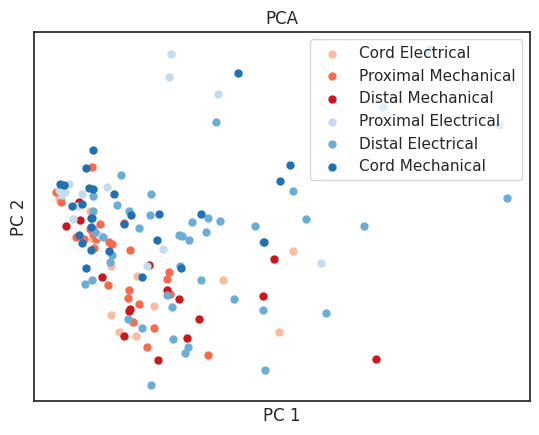

In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new_features = load_feature_df("STIM")

data, data_labels = df_new_features.iloc[:, :-2], df_new_features.iloc[:, -2:-1]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA() #(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


class_list = df_new_features['label_name'].unique().tolist()
no_of_points = len(class_list)

for c in range(no_of_points):
    indices = data_labels.query(f'label == {c}').index
    class_data = reduced_data[indices]
    plt.scatter(class_data[:, 0], class_data[:, 1],
                color=all_colors[c], label=class_list[c], s=25)
            
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.title(f'PCA')
plt.show()

In [84]:
df_new_features['reduced_data'].head(2)

0   -3.576097
1   -1.111298
Name: reduced_data, dtype: float64

(147,)


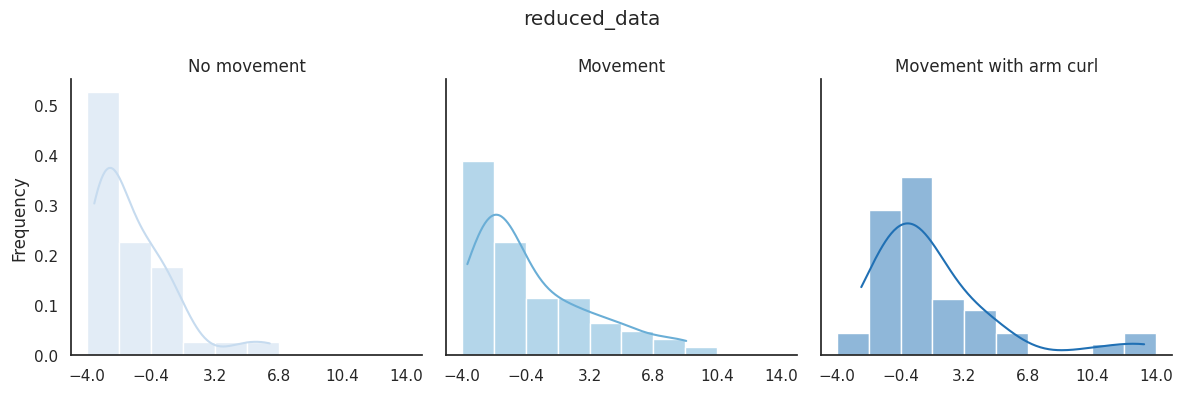

[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897), (0.41708573625528644, 0.6806305267204922, 0.8382314494425221), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563)]
['No movement', 'Movement', 'Movement with arm curl']


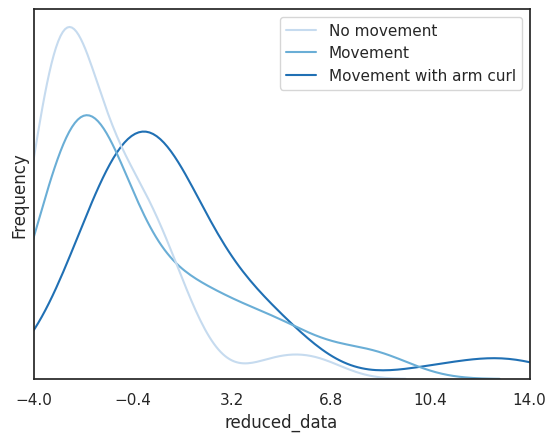

In [83]:
print(reduced_data[:, 0].shape)
df_new_features['reduced_data'] = reduced_data[:, 0]
visualize_hist_separate(df_new_features, 'reduced_data')

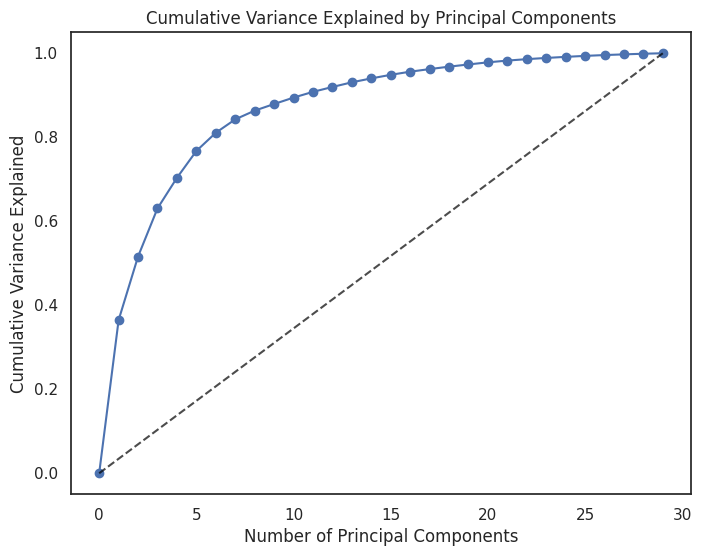

In [131]:
# Calculate cumulative variance explained

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance = np.insert(cumulative_variance, 0, 0)

# Plot the variance-explained graph
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance, marker='o')
plt.plot([0, len(cumulative_variance)-1], [0, 1], linestyle='dashed', color='black', alpha=0.7)
# plt.xticks(np.arange(1, len(cumulative_variance) + 1))

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
# plt.grid(True)
plt.show()

In [144]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

In [132]:
import numpy as np
from sklearn.mixture import GaussianMixture

X = reduced_data
n_components_range = range(1, 11)

# Initialize empty lists to store BIC values
bic_values = []

# Fit GMM models for different numbers of components and calculate BIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_values.append(gmm.bic(X))

optimal_n_components_bic = np.argmin(bic_values) + 1

print("Optimal number of components (BIC):", optimal_n_components_bic)


Optimal number of components (BIC): 6


In [133]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

# Generate sample data for clustering
X = reduced_data
y_true = df_features['labels']['stim_class'].values.astype(int)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Perform Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

print("GMM:")
print("Silhouette Score:", silhouette_score(X, gmm_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, gmm_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, gmm_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, gmm_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(y_true, gmm_labels))

print()

# Evaluate clustering results using various metrics
print("K-means:")
print("Silhouette Score:", silhouette_score(X, kmeans_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, kmeans_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, kmeans_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(y_true, kmeans_labels))


GMM:
Silhouette Score: 0.21359068799531442
Calinski-Harabasz Index: 36.41147496125993
Davies-Bouldin Index: 1.6568058907072094
Adjusted Rand Index: 0.0326058795154187
Normalized Mutual Information: 0.10969632445727025

K-means:
Silhouette Score: 0.19225440116737058
Calinski-Harabasz Index: 38.44774264913063
Davies-Bouldin Index: 1.729367898370537
Adjusted Rand Index: 0.05148099611301635
Normalized Mutual Information: 0.10069525555402875


In [153]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

data = reduced_data

NO_OF_CLUSTERS = 6
GMM = GaussianMixture(n_components = NO_OF_CLUSTERS, random_state=517).fit(data)
cluster = GMM.predict(data)
centroids = GMM.means_

In [154]:
def plot_ellipse(centroids, covariances, ax, color):
    covariance_matrix = covariances
    mean_x, mean_y = centroids

    # Step 1: Eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 2: Calculate the principal axes and angles
    principal_axes = eigenvectors.T
    angle = -np.arctan2(principal_axes[1, 0], principal_axes[0, 0])

    # Step 3: Choose confidence levels (e.g., 1, 2, and 3 standard deviations)
    confidence_levels = [1, 2, 3]

    # Step 4: Plot the ellipses

    for level in confidence_levels:
        width = 2 * level * np.sqrt(eigenvalues[0])
        height = 2 * level * np.sqrt(eigenvalues[1])
        ellipse = Ellipse(xy=(mean_x, mean_y), width=width, height=height,
         angle=np.degrees(angle), color=color)
        ellipse.set_alpha(0.2)  # Set the ellipse transparency
        ax.add_patch(ellipse)

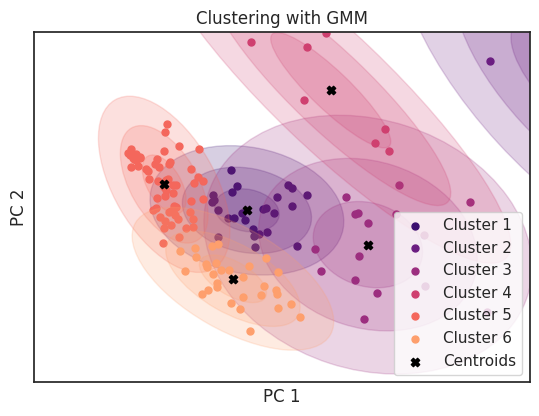

In [156]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=NO_OF_CLUSTERS))

for k in range(NO_OF_CLUSTERS):
    plot_ellipse(centroids[k], GMM.covariances_[k], ax, colors[k])
    plt.scatter(*data[cluster==k, :].T, s=25, color=colors[k], label=f'Cluster {k+1}')
    
plt.scatter(*centroids.T, marker='X', c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-7, 10)
plt.ylim(-6, 6)
plt.title('Clustering with GMM')
plt.legend()

In [ ]:
# Clustering - KMeans

from sklearn.cluster import KMeans

data = reduced_data

NO_OF_CLUSTERS = 3
# Create a KMeans instance with 3 clusters
kmeans = KMeans(n_clusters=NO_OF_CLUSTERS, random_state=42)

# Fit the KMeans model to the data and predict the cluster labels
cluster_labels = kmeans.fit_predict(data)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=3))

for c in range(NO_OF_CLUSTERS): 
    # Separate the data points by cluster
    cluster_data = data[cluster_labels == c]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {c+1}', color=colors[c])

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-7, 10)
plt.ylim(-6, 6)
plt.title('Clustering with K-Means')
plt.legend()
plt.show()

In [ ]:
# Clustering - AgglomerativeClustering

from sklearn.cluster import AgglomerativeClustering

data = reduced_data

NO_OF_CLUSTERS = 3
# Create a KMeans instance with 3 clusters
agg_clustering = AgglomerativeClustering(n_clusters=NO_OF_CLUSTERS)

# Fit the KMeans model to the data and predict the cluster labels
cluster_labels = agg_clustering.fit_predict(data)

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=3))

for c in range(NO_OF_CLUSTERS): 
    # Separate the data points by cluster
    cluster_data = data[cluster_labels == c]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {c+1}', color=colors[c])

# Plot the cluster centers
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-7, 10)
plt.ylim(-6, 6)
plt.title('Agglomerative Clustering')
plt.legend()
plt.show()

In [ ]:
# # Plot angles and p-likelihood

# N = 2
# X = df_features['features', 'angles'].values[N-1:N]
# y = df_features['labels'].iloc[N-1:N]

# movement_types = [
#     "No movement",
#     "Movement",
#     "Movement with arm curl"
# ]

# tx = driver.tx

# stim_class_list = driver.stim_class_list

# for i in range(1):
#     feature = X[i]
#     label = y.iloc[i]
#     print(df_features['metadata', 'filename'].iloc[i])
#     print(movement_types[label['move_class']],"|", stim_class_list[label['stim_class']])
#     for k in range(feature.shape[-1]):
#         plt.plot(tx, X[i][:, k], label=k)
#     plt.legend()
#     plt.show()

# X = df_features['features', 'p'].values[N-1:N]
# y = df_features['labels'].iloc[N-1:N]

# movement_types = [
#     "No movement",
#     "Movement",
#     "Movement with arm curl"
# ]

# tx = driver.tx

# stim_class_list = driver.stim_class_list

# for i in range(1):
#     feature = X[i]
#     label = y.iloc[i]
#     for k in range(feature.shape[-1]):
#         plt.plot(tx, X[i][:, k], label=k)
#     plt.legend()
#     plt.show()

In [ ]:
# %matplotlib tk

# import matplotlib.pyplot as plt
# import numpy as np

# WIDTH, HEIGHT = 640, 480

# R = 1
# df_ = df_features.iloc[R]
# print(df_['metadata', 'filename'])
# xy = df_['features', 'xy']
# x_coords, y_coords = xy[..., 0], xy[..., 1]

# y_coords = HEIGHT-y_coords

# num_points = xy.shape[1]  # Number of points to visualize

# # Create a figure and axis
# fig, ax = plt.subplots()

# colors = plt.cm.Blues(np.linspace(1, 0.2, num=num_points))

# # Create an empty scatter plot for each point
# scatters = [ax.scatter([], [], color=colors[i]) for i in range(num_points)]

# # Set up the axis limits
# ax.set_xlim(0, WIDTH)
# ax.set_ylim(0, HEIGHT)

# # Function to update the scatter plots
# def update_plots(i):
#     # Iterate through each point
#     for j in range(num_points):
#         # Get the current x and y coordinates for the point
#         x = x_coords[i, j]
#         y = y_coords[i, j]
        
#         # Update the scatter plot data for the point
#         scatters[j].set_offsets([(x, y)])
        
#     # Set the title to the current index
#     ax.set_title(f"Time Step: {driver.tx[i]:0.1f} s")
    
#     # Pause for a short duration (in seconds) to observe each point
#     plt.pause(1.5*1/30)

# # Iterate through each time step and update the plots
# for i in range(xy.shape[0]):
#     update_plots(i)

# # Show the final plots in a new window
# plt.show()


In [ ]:
df_features['labels', 'move_class'].value_counts()

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM


num_classes = 3

# Load and preprocess the data
X = np.stack(df_features['features', 'angles'].values, axis=-1)
X = X.reshape(-1, X.shape[-1]).T
y = df_features['labels', 'stim_class'].values.astype(int)

# Encode the target variable
# le = LabelEncoder()
# y = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2]), activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=300, batch_size=4, verbose=0);

In [ ]:
%matplotlib inline
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Perform predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = [0, 1, 2]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Visualize the confusion matrix as a heatmap
first_words = [string.split()[0] for string in driver.stim_class_list]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=first_words, yticklabels=first_words)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Stimulation point of contact - using DLC')
plt.show()